# Step 2: Modeling

***Predict Brain Tissue Segmentation Masks from Brain MRI Scans***

## Contents


1. [Train Models on Sagemaker](#Train-Models-on-SageMaker)
1. [Inference Endpoints](#Inference-Endpoint)
1. [Model Evaluation](#Model-Evaluation)
1. [Clean up](#Clean-up)



##  Import libraries  & Initialize variables 


In [10]:
import numpy as np
from PIL import Image
import boto3
import os
from glob import glob
import imageio
from sklearn.model_selection import train_test_split
import time
import urllib
import tarfile
import shutil
import json
import matplotlib.pyplot as plt

from utils.utils import *
%matplotlib inline

In [9]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNet
import os

sess = sagemaker.Session()
sagemaker_session = sagemaker.Session()  

#estimator.sagemaker_session=sagemaker_session
role = get_execution_role()

## Train-Models-on-SageMaker
### Upload data

Firstly, we're going to upload the pre-processed data to S3 using the <tt>upload_data</tt> method to put the objects in a default SageMaker bucket. We're going to pass the parent directory containing the compressed files to the method, which syncs the child tree to the bucket.

In [7]:
## local path and s3 path

data_bucket = sess.default_bucket()  # or <YOUR-S3-BUCKET>
data_prefix = 'DICOM/oasis_cross-sectional_disc1.tar' # or <YOUR-S3-PREFIX>
data_dir = './data'   #or <YOUR-DATA-DIR> in  sagemaker 


tar_gz_dir = os.path.join(data_dir, 'tar_gz')
tar_gz_train_dir = os.path.join(tar_gz_dir, "train")
tar_gz_validation_dir = os.path.join(tar_gz_dir, "validation")



In [11]:
prefix = 'brain-segmentation-tar-gz'
data_bucket = sagemaker_session.upload_data(path=tar_gz_dir, key_prefix=prefix) ## upload the dataset to S3 with defined path
print(tar_gz_dir)
print(data_bucket)

./data/tar_gz
s3://sagemaker-us-east-1-741261399688/brain-segmentation-tar-gz


### Entry Point

As mentioned, the <tt>MXNet</tt> estimator uses a default MXNet container and the user simply provides the code that defines the training.

The script we'll be passing as an entry point to the estimator is <tt>brain_segmentation.py</tt>:

In [16]:
!cat source_dir/brain_segmentation.py

from __future__ import absolute_import
import boto3
import base64
import json
import io
import os
import argparse
import mxnet as mx
from mxnet import nd
import numpy as np
mx.test_utils.download("https://raw.github.com/drj11/pypng/main/code/png.py", "png.py")
import png
#from sagemaker_mxnet_training.training_utils import save

import tarfile
from iterator import DataLoaderIter
from losses_and_metrics import avg_dice_coef_metric
from models import build_unet, build_enet
import logging

import brain_segmentation_s3_transform

logging.getLogger().setLevel(logging.INFO)

from inference import *

def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument("--batch-size", type=int, default=8)
    parser.add_argument("--epochs", type=int, default=1)
    parser.add_argument("--learning-rate", type=float, default=0.1)
    parser.add_argument("--class-weights", type=list, default=[1.35, 17.18,  8.29, 12.42])
    parser.add_argument("--network", type=str, default="local")


In the training script, we define the training loop, which constitutes the life-cycle of the training job. Some points to notice:
* **hyperparameters**: This hyperparameter mapping is something that we'll pass to the estimator as part of the training configuration.
* **network**: This hyperparameter defines the network to train, either <tt>unet</tt> or <tt>enet</tt>.
* **local imports**: The model, iterator, and loss/metric definitions are in local modules. We will pass this script, as well as accompanying modules, to the estimator

I encourage you to look at these modules for deeper insights into training these networks.

## Model training using GPU instance, Refer to the documentation [here](https://aws.amazon.com/sagemaker/pricing/) for list of GPU instances and their prices. 

I selected **ml.g4dn.4xlarge** with vCPU = 16 and Memory = 64 GiB 

+ training instance = ml.g4dn.4xlarge @ $1.505/hour*

+ training time = *27 mins*


+ training cost = $1.505*27/60 
              

#### Initialize hyperparameters

In [117]:
## model name 
unet_gpu_job = 'DEMO-unet-g4dn-job-' + \
    time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

## hyperparameters
hyperparameters={
                    'learning-rate': 1E-3 * 16,
                    'class-weights': [1.35, 17.18,  8.29, 12.42],
                    'network': 'unet',
                    'batch-size': 32,
                    'epochs': 10  ## number of epochs
                        }

## model using MXNet Unet
unet_gpu_estimator = MXNet(entry_point='brain_segmentation.py',
                        base_job_name=unet_gpu_job,
                        source_dir='./source_dir',
                        role=role,
                        instance_count=1,
                        instance_type='ml.g4dn.16xlarge',
                        framework_version='1.6',
                        py_version='py3',
                        hyperparameters=hyperparameters,
                       env={'MMS_DEFAULT_RESPONSE_TIMEOUT': '86400',"PYTHONUNBUFFERED": "1" },) 


#### Model fitting 

In [ ]:
%%time
train_s3 = sagemaker.TrainingInput(s3_data=os.path.join(
    data_bucket, "train"), distribution='FullyReplicated')
validation_s3 = sagemaker.TrainingInput(s3_data=os.path.join(
    data_bucket, "validation"), distribution='FullyReplicated')

unet_gpu_estimator.fit({'train': train_s3, 'test': validation_s3})

2021-09-28 11:08:08 Starting - Starting the training job...
2021-09-28 11:08:31 Starting - Launching requested ML instancesProfilerReport-1632827288: InProgress
.........
2021-09-28 11:10:08 Starting - Preparing the instances for training.........
2021-09-28 11:11:35 Downloading - Downloading input data...
2021-09-28 11:11:52 Training - Downloading the training image...
2021-09-28 11:12:32 Training - Training image download completed. Training in progress.2021-09-28 11:12:25,123 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-09-28 11:12:25,146 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":32,"class-weights":[1.35,17.18,8.29,12.42],"epochs":10,"learning-rate":0.016,"network":"unet"}', 'SM_USER_ENTRY_POINT': 'brain_segmentation.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],

### Let's see fitted models

In [73]:
unet_gpu_estimator.__dict__

{'framework_version': '1.6',
 'py_version': 'py3',
 'role': 'arn:aws:iam::741261399688:role/sagemaker-ai-demo-v2-SageMakerIamRole-1KDLPV0RXG7IV',
 'instance_count': 1,
 'instance_type': 'ml.g4dn.16xlarge',
 'volume_size': 30,
 'volume_kms_key': None,
 'max_run': 86400,
 'input_mode': 'File',
 'tags': None,
 'metric_definitions': None,
 'model_uri': None,
 'model_channel_name': 'model',
 'code_uri': None,
 'code_channel_name': 'code',
 'sagemaker_session': <sagemaker.session.Session at 0x7fefbb47b710>,
 'base_job_name': 'DEMO-unet-g4dn-job-2021-09-27-12-13-11',
 '_current_job_name': 'DEMO-unet-g4dn-job-2021-09-27-12-13-11-2021-09-27-12-13-13-533',
 'output_path': 's3://sagemaker-us-east-1-741261399688/',
 'output_kms_key': None,
 'latest_training_job': <sagemaker.estimator._TrainingJob at 0x7fefd07b3fd0>,
 'jobs': [<sagemaker.estimator._TrainingJob at 0x7fefd07b3fd0>],
 'deploy_instance_type': None,
 '_compiled_models': {},
 'subnets': None,
 'security_group_ids': None,
 'encrypt_inter_

In [65]:
unet_gpu_estimator.__dict__
s3_model=unet_gpu_estimator.__dict__['output_path'] ## model artifact saved in S3 
base_job= unet_gpu_estimator.__dict__['_current_job_name']

s3_model=s3_model+base_job+'/output/model.tar.gz'
s3_model

's3://sagemaker-us-east-1-741261399688/DEMO-unet-g4dn-job-2021-09-27-10-03-53-2021-09-27-10-03-54-220/output/model.tar.gz'

## Deployment 

In [92]:
%%time

unet_gpu_estimator.sagemaker_session=sagemaker.local.LocalSession()
predictor = unet_gpu_estimator.deploy(instance_type= 'local',initial_instance_count=1)

ClientError: An error occurred (ValidationException) when calling the describe_training_job operation: Could not find local training job

In [75]:
predictor.serializer = sagemaker.serializers.JSONSerializer(content_type='application/json')

In [76]:
processed_data_dir = os.path.join(data_dir, 'brain_mri', 'data')
validation_dir = os.path.join(processed_data_dir, 'validation')
test_brain = np.array(Image.open(os.path.join(validation_dir, 'OAS1_0004_MR1_mpr_n4_anon_111_t88_26.png')))[np.newaxis, np.newaxis,  :]

In [78]:
jsonstr=json.dumps(test_brain.tolist())
predictor.predict(jsonstr)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (503) from primary with message "{
  "code": 503,
  "type": "InternalServerException",
  "message": "Prediction failed"
}
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/DEMO-unet-g4dn-job-2021-09-27-12-13-11-2021-09-28-02-21-51-316 in account 741261399688 for more information.

### Deployment 2 through model artifect in S3 

In [79]:
s3_model

's3://sagemaker-us-east-1-741261399688/DEMO-unet-g4dn-job-2021-09-27-10-03-53-2021-09-27-10-03-54-220/output/model.tar.gz'

In [80]:
from sagemaker.mxnet.model import MXNetModel
#s3_model='s3://sagemaker-us-east-1-741261399688/DEMO-p3-unet-job-2021-09-20-12-34-02-2021-09-20-12-34-03-294/source/sourcedir.tar.gz'
mxnet_model = MXNetModel(
    model_data=s3_model,
    role=role,
    framework_version='1.6',
    py_version='py3',
    entry_point="inference.py",
    #source_dir='./source_dir'
)

In [81]:
%%time
predictor = mxnet_model.deploy(instance_type='ml.m5.2xlarge', #local 
                               initial_instance_count=1)

-----------!CPU times: user 2.18 s, sys: 223 ms, total: 2.4 s
Wall time: 5min 34s


In [96]:
predictor.serializer = sagemaker.serializers.JSONSerializer(content_type='application/json')
result=predictor.predict(jsonstr)

In [97]:
predictor.__dict__

{'endpoint_name': 'mxnet-inference-2021-09-28-07-57-04-815',
 'sagemaker_session': <sagemaker.session.Session at 0x7fefbb7e9890>,
 'serializer': <sagemaker.serializers.JSONSerializer at 0x7fefba3b9ed0>,
 'deserializer': <sagemaker.deserializers.JSONDeserializer at 0x7fefd7337290>,
 '_endpoint_config_name': None,
 '_model_names': None,
 '_context': None}

In [98]:
test_mask = np.array(Image.open(os.path.join(
    validation_dir, 'OAS1_0004_MR1_mpr_n4_anon_111_t88_26_mask.png')))[np.newaxis, np.newaxis, :]

In [112]:
result[0][1]

0.0

In [114]:
np.array(result)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

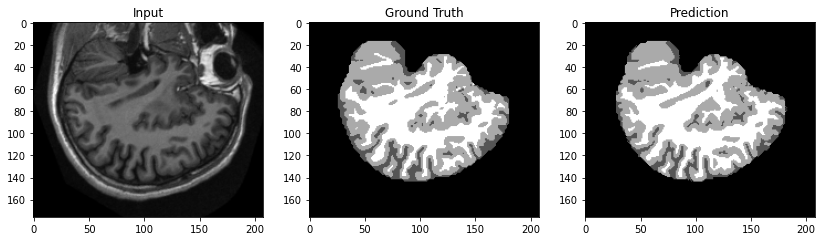

In [116]:
plt.figure(figsize=(14, 14))
plt.subplot(131)
plt.title('Input')
plt.imshow(test_brain[0][0], cmap=plt.cm.gray)
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(test_mask[0][0], cmap=plt.cm.gray)
plt.subplot(133)
plt.title('Prediction')
#response = json.loads(result)
plt.imshow(np.array(result), cmap=plt.cm.gray)